In [1]:
import pandas as pd
import os
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras_cv
import keras
import joblib
from tqdm.notebook import tqdm
import numpy as np

2024-04-24 09:19:35.930963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 09:19:35.931125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 09:19:36.118465: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"
SPEC_DIR = "/tmp/dataset/hms-hbac"
# os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [4]:
# Define a function to process a single eeg_id for test data
def process_test_spec(spec_id):
    spec_path = f"{BASE_PATH}/test_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T  # Fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/test_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_test_spec)(spec_id)
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [5]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [6]:
modelE = keras.models.load_model("/kaggle/input/hms-nn-outputs/Saved Model/EfficientNetV2_best_model.keras")
modelD = keras.models.load_model("/kaggle/input/hms-nn-outputs/Saved Model/DenseNetV2_best_model.keras")
modelR = keras.models.load_model("/kaggle/input/hms-nn-outputs/Saved Model/ResNetV2_best_model.keras")

In [7]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

In [8]:
predE = modelE.predict(test_ds)
predD = modelD.predict(test_ds)
predR = modelR.predict(test_ds)

I0000 00:00:1713950506.315385     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-24 09:21:46.331471: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[8.4546683e-03 3.1703297e-02 1.2349279e-04 9.3794221e-01 5.4124352e-03
  1.6363883e-02]]
[[0.14378437 0.10511595 0.00672885 0.21842788 0.15931499 0.366628  ]]
[[0.4687799  0.09088643 0.01343188 0.04368013 0.04695553 0.33626613]]


In [28]:
pred_df_E = test_df[["eeg_id"]].copy()
pred_df_D = test_df[["eeg_id"]].copy()
pred_df_R = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df_E[target_cols] = predE.tolist()
pred_df_D[target_cols] = predD.tolist()
pred_df_R[target_cols] = predR.tolist()
pred_df = pd.concat([pred_df_E, pred_df_D, pred_df_R])
pred_df

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.008455,0.031703,0.000123,0.937942,0.005412,0.016364
0,3911565283,0.143784,0.105116,0.006729,0.218428,0.159315,0.366628
0,3911565283,0.468780,0.090886,0.013432,0.043680,0.046956,0.336266


### **Plotting Graphs**

In [29]:
import matplotlib.pyplot as plt
import pickle

In [44]:
with open('/kaggle/input/hms-nn-outputs/Saved Model/EfficientNetV2.pkl', 'rb') as f:
    hist1 = pickle.load(f)

In [45]:
hist1.keys()

dict_keys(['loss', 'val_loss', 'learning_rate'])

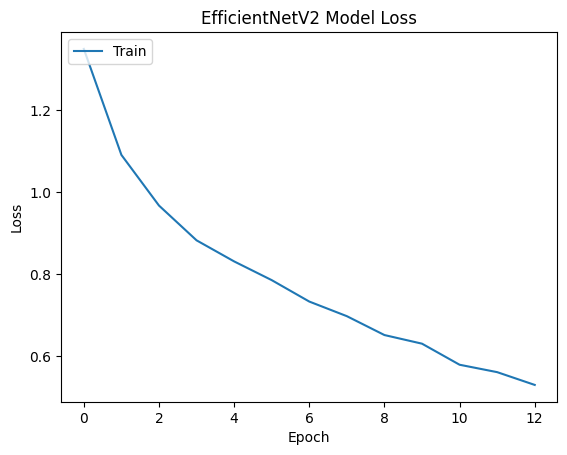

In [46]:
plt.plot(hist1['loss'])
plt.title('EfficientNetV2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

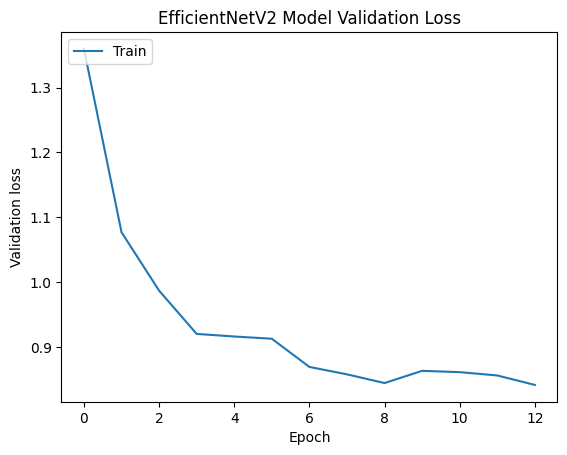

In [47]:
plt.plot(hist1['val_loss'])
plt.title('EfficientNetV2 Model Validation Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

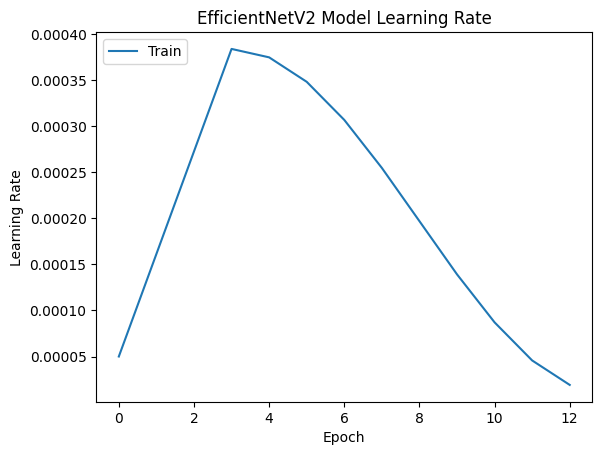

In [48]:
plt.plot(hist1['learning_rate'])
plt.title('EfficientNetV2 Model Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

In [49]:
with open('/kaggle/input/hms-nn-outputs/Saved Model/DenseNetV2.pkl', 'rb') as f:
    hist2 = pickle.load(f)

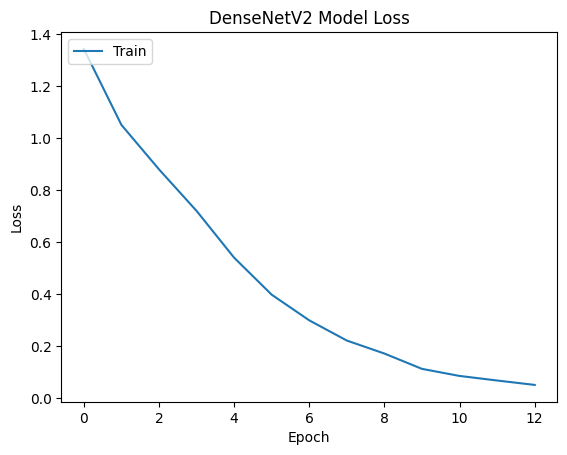

In [50]:
plt.plot(hist2['loss'])
plt.title('DenseNetV2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

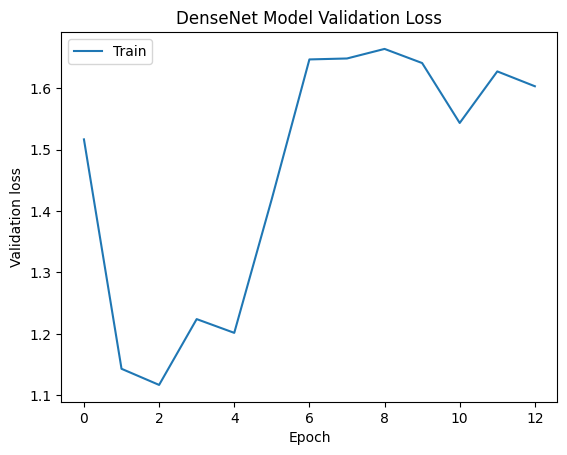

In [51]:
plt.plot(hist2['val_loss'])
plt.title('DenseNet Model Validation Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

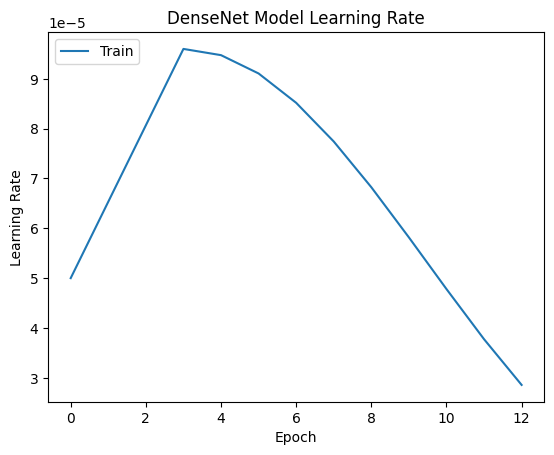

In [52]:
plt.plot(hist2['learning_rate'])
plt.title('DenseNet Model Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

In [53]:
with open('/kaggle/input/hms-nn-outputs/Saved Model/ResNetV2.pkl', 'rb') as f:
    hist3 = pickle.load(f)

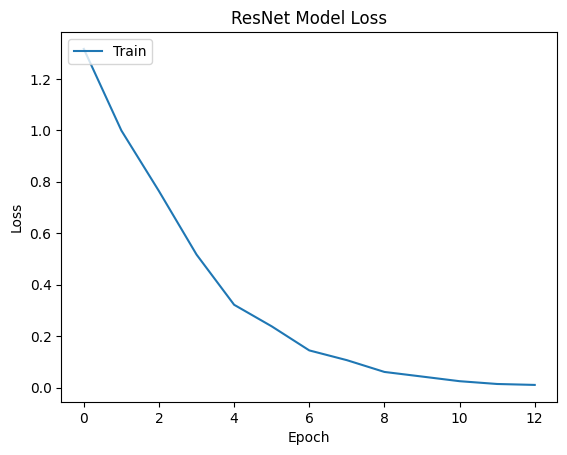

In [54]:
plt.plot(hist3['loss'])
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

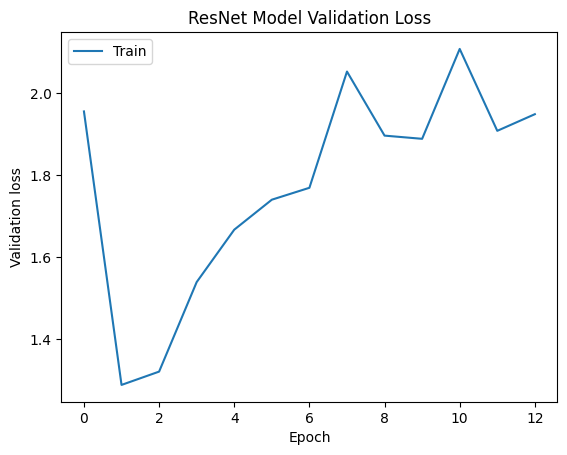

In [55]:
plt.plot(hist3['val_loss'])
plt.title('ResNet Model Validation Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

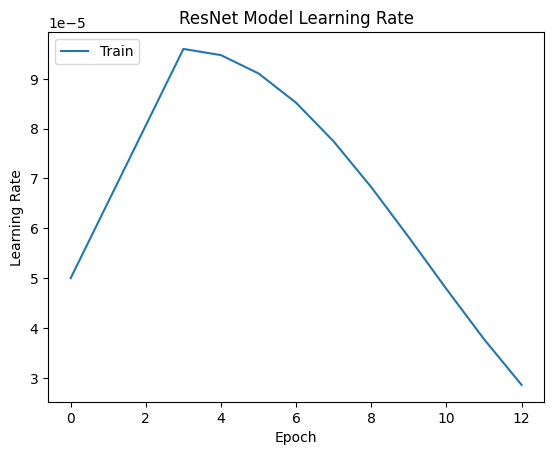

In [56]:
plt.plot(hist3['learning_rate'])
plt.title('ResNet Model Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

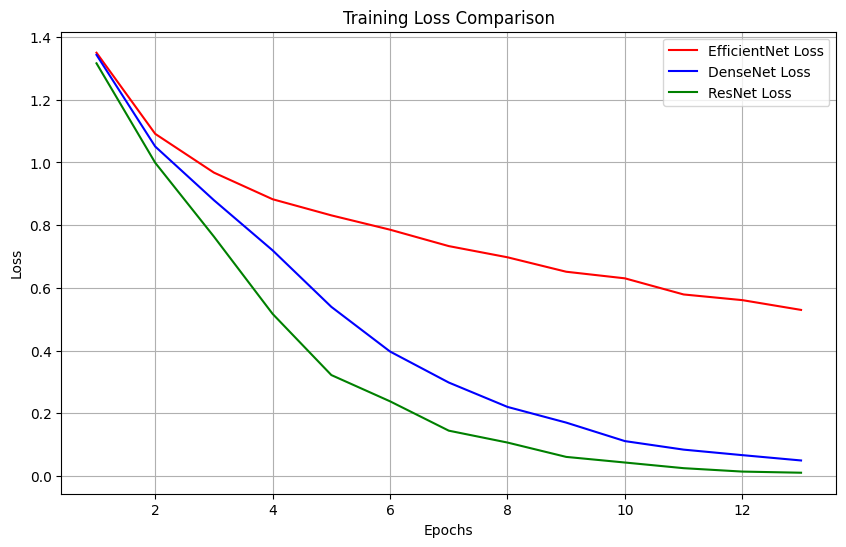

In [59]:
loss1 = hist1['loss']
loss2 = hist2['loss']
loss3 = hist3['loss']

epochs = range(1, len(loss1) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss1, 'r', label='EfficientNet Loss')
plt.plot(epochs, loss2, 'b', label='DenseNet Loss')
plt.plot(epochs, loss3, 'g', label='ResNet Loss')

plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()


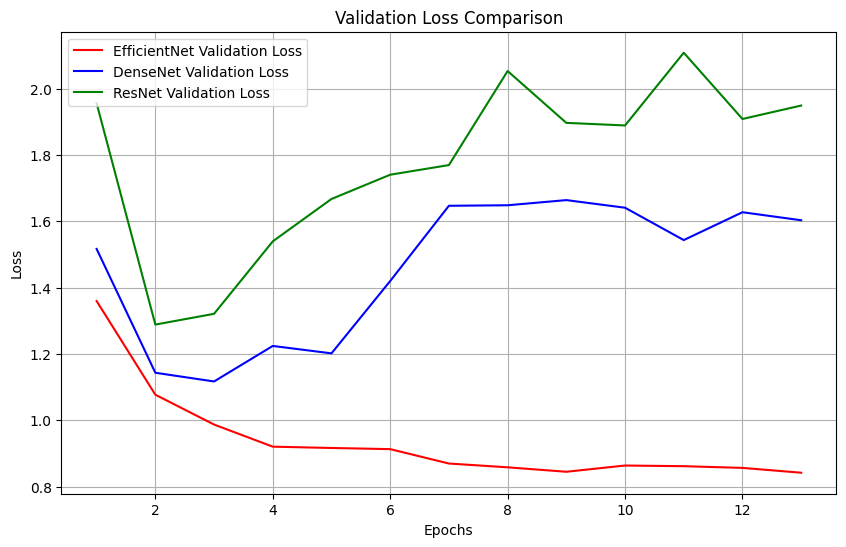

In [60]:
loss1 = hist1['val_loss']
loss2 = hist2['val_loss']
loss3 = hist3['val_loss']

epochs = range(1, len(loss1) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss1, 'r', label='EfficientNet Validation Loss')
plt.plot(epochs, loss2, 'b', label='DenseNet Validation Loss')
plt.plot(epochs, loss3, 'g', label='ResNet Validation Loss')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()


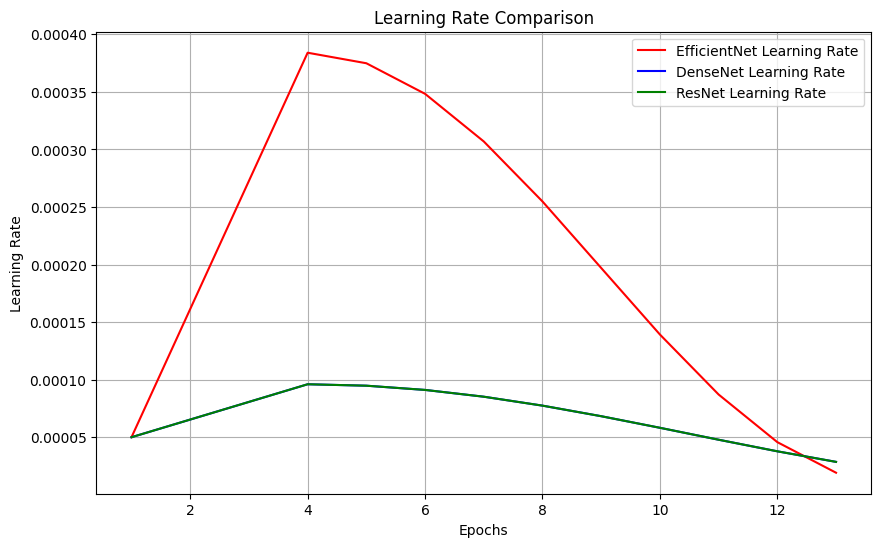

In [62]:
lr1 = hist1['learning_rate']
lr2 = hist2['learning_rate']
lr3 = hist3['learning_rate']

epochs = range(1, len(loss1) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, lr1, 'r', label='EfficientNet Learning Rate')
plt.plot(epochs, lr2, 'b', label='DenseNet Learning Rate')
plt.plot(epochs, lr3, 'g', label='ResNet Learning Rate')

plt.title('Learning Rate Comparison')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.grid(True)
plt.show()
